In [1]:
import networkx as nx
import numpy as np
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
import csv
import os
import itertools

In [2]:
from scripts.utility import *
from scripts.features import *

# Features
It is a good idea to save our features in text files, so that we only have to calculate them once. Later on when we employ clustering, we can just read the values off of these files instead of iterating over the graphs again, which is time consuming.

## 1. Geometrical

### 1.1 Number of nodes and edges

In [ ]:
# Calculate the number of nodes and edges for each network and save them to files
with open('features/n_nodes.txt', 'w') as node_file, open('features/n_edges.txt', 'w') as edge_file:
    for network_id, G in graph_generator():
        node_file.write(network_id + '\t' + str(nx.number_of_nodes(G)) + '\n') # nx.number_of_nodes() function
        edge_file.write(network_id + '\t' + str(nx.number_of_edges(G)) + '\n') # use tab character \t, not two spaces
        
###NOTE: Have to pull features from github before running script
##IDEA: Can calculate every feature on the same loop

### 1.2 Average node degree

In [ ]:
# Calculate the average node degree, i.e. the average number of edges that are connected to a node,
# for each network and write them to a file
with open('features/average_node_degree.txt', 'w') as file:
    for network_id, G in graph_generator(): # check this access to graph_generator
        average_node_degree = np.mean(list(G.degree().values()))
        file.write(network_id + '\t' + str(average_node_degree) + '\n')

### 1.3 Vein density

Vein density **$\sigma$** is calculated by summing the total length of all veins and dividing by total leaf area.


In [ ]:
save_feature(vein_density, skip_existing=True, clean=False)

### 1.4 Areole area

Areole area **$A$** is obtained calculating basic cycle areas using the standard formula for the area of a general polygon.

In [ ]:
save_feature(areole_area, skip_existing=True, clean=False)

### 1.5 Areole density 

Areole density **$\rho_A$** is the total number of areoles divided by leaf area.

In [ ]:
save_feature(areole_density, skip_existing=True, clean=False)

### 1.6 Weighted vein thickness

Weighted vein thickness **$d$** is calculated as the total sum of the product radius*length of each
    individual vein segment divided by total vein length

In [ ]:
save_feature(weighted_vein_thickness, skip_existing=True, clean=False)

## 2. Topological

### 2.1 Nesting number

In [ ]:
save_feature(nesting_numbers, skip_existing=True, clean=True)

# Data Analysis

In [ ]:
data = read_features()

In [ ]:
feature_names = [
    'topological_length',  
    'nesting_number_weighted_no_ext',
    #'nesting_number_unweighted',
    #'nesting_number_weighted',
    'nesting_number_unweighted_no_ext',
    'vein_density',
    'vein_distance',
    'areole_area',
    'areole_density',
    'weighted_vein_thickness',
    #'average_node_degree',
    #'n_edges',
    #'n_nodes',
    
]

feature_labels = {
    'topological_length'              : r'$L_{top}$',
    'nesting_number_weighted'         : r'$i_w$',
    'nesting_number_weighted_no_ext'  : r'$i_w^{no}$',
    'nesting_number_unweighted'       : r'$i_u$',
    'nesting_number_unweighted_no_ext': r'$i_u^{no}$',
    'vein_density'                    : r'$\sigma$',
    'vein_distance'                   : r'$a$',
    'areole_area'                     : r'$A$',
    'areole_density'                  : r'$\rho_A$',
    'weighted_vein_thickness'         : r'$d$',
    'average_node_degree'             : r'$deg_N$',
    'n_edges'                         : r'$N_e$',
    'n_nodes'                         : r'$N_n$',
}

In [ ]:
network_ids = sorted(data['nesting_number_weighted'].keys())

## Principal Component Analysis

In [ ]:
X = []
for feature_name in feature_names:
    row = [data[feature_name][network_id] for network_id in network_ids]
    X.append(row)
X = np.array(X)
X = X.T
X = X - np.mean(X, axis=0)
X1 = X / np.std(X, axis=0)
X2 = X / np.max(X, axis=0)

In [ ]:
for X in [X1, X2]:
    pca = PCA()
    pca.fit(X)
    
    normalized_eigenvalues = pca.explained_variance_ratio_
    #print(normalized_eigenvalues)
    
    principal_components = pca.components_
    #print(principal_components)
    
    scaled_principal_components = (normalized_eigenvalues * principal_components.T).T
    #print(scaled_principal_components)
    
    relative_feature_contributions = np.sum(abs(scaled_principal_components), axis=0)
    #print(relative_feature_contributions)
    
    
    fig, ax = plt.subplots()
    x = np.arange(len(relative_feature_contributions))
    ax.bar(x, relative_feature_contributions)
    labels = [feature_labels[name] for name in feature_names]
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    
    width = 0.35

    fig, ax = plt.subplots()
    x = np.arange(len(relative_feature_contributions))
    ax.bar(x, abs(principal_components[0,:]), width)
    ax.bar(x + width, abs(principal_components[1,:]), width)
    #ax.bar(x + 2*width, abs(principal_components[2,:]), width)

    labels = [feature_labels[name] for name in feature_names]
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(labels)

## Clustering

In [ ]:
n_subset = 20

species = [species_from_id(network_id) for network_id in network_ids]

genera = list(sorted(set([spec['genus'] for spec in species])))

networks_from_genus = {genus: [] for genus in genera}
for network_id in network_ids:
    networks_from_genus[species_from_id(network_id)['genus']].append(network_id)

genera_ge4 = []
for genus, networks in networks_from_genus.items():
    #if genus == 'Parkia': continue
    if len(networks) >= n_subset:
        genera_ge4.append(genus)
        print(genus)
        
network_ids_ge4 = list(itertools.chain(*[networks_from_genus[genus][:n_subset] for genus in genera_ge4]))

In [ ]:
X = []
for feature_name in feature_names:
    row = [data[feature_name][network_id] for network_id in network_ids_ge4]
    X.append(row)
X = np.array(X)
X = X.T
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

In [ ]:
kmeans = KMeans(n_clusters=len(genera_ge4), n_init=60).fit(X)

In [ ]:
count_matrix = np.zeros((len(genera_ge4), len(genera_ge4)), dtype=int)
for k in range(len(genera_ge4)):
    labels = kmeans.labels_[k*n_subset:(k+1)*n_subset]
    unique, counts = np.unique(labels, return_counts=True)
    for index, value in zip(unique, counts):
        count_matrix[k, index] = value
        
print(count_matrix)

# NOTE: can be much improved, higher values should have more weight, shared maxima are a problem
center_from_genus = {}
for center_index, genus_index in enumerate(np.argmax(count_matrix, axis=0)):        
    center_from_genus[genera_ge4[genus_index]] = kmeans.cluster_centers_[center_index]

In [ ]:
%matplotlib inline
colors = ['blue', 'orange', 'green', 'red', 'violet']
index_pairs = [[2, b] for b in range(3, 8)] + [[0, b] for b in range(3, 8)]
fig, axes = plt.subplots(5, 2, figsize=(20,40))

for ax, feature_indices in zip(axes.flat, index_pairs):
    for genus, color in zip(genera_ge4, colors):       
        X_genus = X[[k for k, network_id in enumerate(network_ids_ge4) if network_id in networks_from_genus[genus]],:]

        x = X_genus[:, feature_indices[0]]
        y = X_genus[:, feature_indices[1]]

        ax.scatter(x, y, label=genus, color=color, alpha=0.65)
        ax.scatter(center_from_genus[genus][feature_indices[0]], center_from_genus[genus][feature_indices[1]], color=color, s=200, zorder=2)

    ax.set_xlabel(feature_labels[feature_names[feature_indices[0]]])
    ax.set_ylabel(feature_labels[feature_names[feature_indices[1]]])
    
    #if feature_names[feature_indices[1]] == 'areole_density':
    #    ax.set_ylim(-1e-4, 1e-4)

    ax.legend()
#plt.tight_layout()

In [ ]:
_, G = graph_from_data('data/networks-BronxA/BronxA_019_binary_corrected_graph.node_positions.txt',
                       'data/networks-BronxA/BronxA_019_binary_corrected_graph.edgelist.txt')

In [ ]:
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos=pos, node_size=0.001)

In [ ]:
X = []
for feature_name in feature_names:
    row = [data[feature_name][network_id] for network_id in network_ids]
    X.append(row)
X = np.array(X)
X = X.T
#X = X - np.mean(X, axis=0)
#X = X / np.std(X, axis=0)

%matplotlib inline
matplotlib.rcParams.update({'font.size': 15})

colors = ['blue', 'orange', 'green', 'red', 'violet']
index_pairs = [[2, b] for b in range(3, 8)] + [[0, b] for b in range(3, 8)]
fig, axes = plt.subplots(5, 2, figsize=(20,40))

for ax, feature_indices in zip(axes.flat, index_pairs):

    x = X[:, feature_indices[0]]
    y = X[:, feature_indices[1]]
    
    r, p = scipy.stats.pearsonr(x, y)

    ax.scatter(x, y, alpha=0.65, label=r'$r={0:.4f}, p={1:.4f}$'.format(r, p))

    ax.set_xlabel(feature_labels[feature_names[feature_indices[0]]])
    ax.set_ylabel(feature_labels[feature_names[feature_indices[1]]])
    
    if feature_names[feature_indices[1]] == 'vein_density':
        ax.set_ylim(0, 0.005)
        #ax.set_ylim(0, 5.005)
    #if feature_names[feature_indices[1]] == 'areole_density':
    #    ax.set_ylim(-1e-5, 1e-5)
    ax.legend()

#plt.tight_layout()

## Leaf Cuts

In [ ]:
networks_to_be_cut = [
    'BronxA_009', # Brusera gracilipes
    'BronxA_010',
    'BronxA_016', # Protium calanense
    'BronxA_019',
    'BronxA_070', # Apuleia leiocarpa
    'BronxA_071',
    'BronxA_088', # Dalbergia miscolobium
    'BronxA_109',
    'BronxA_075', # Cedrela odorata
    'BronxA_119',   
]

In [ ]:
#for k, network_id in enumerate(networks_to_be_cut[3:4]):
network_id = 'BronxA_119'
path = 'data/networks-BronxA/{}_binary_corrected_graph.'.format(network_id)
_, G = graph_from_data(path + 'node_positions.txt',
                       path + 'edgelist.txt')
#G = clean_graph(G)

In [ ]:
pos = nx.get_node_attributes(G, 'pos')
coords = np.array([pos[key] for key in sorted(nx.get_node_attributes(G, 'pos').keys())])
center = np.mean(coords, axis=0)
coords -= center

phi = -2*np.pi/360 * -(-2)
R = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
coords = np.dot(R, coords.T).T

max_coords = np.max(coords, axis=0)
min_coords = np.min(coords, axis=0)
rect_x = [min_coords[0], max_coords[0], min_coords[0], max_coords[0]]
rect_y = [min_coords[1], min_coords[1], max_coords[1], max_coords[1]]

pos = {key: value for key, value in zip(G.nodes(), coords)}


#plt.subplot(5, 2, k+1)
nx.draw(G, pos=pos, node_size=0.0001, edge_size=0.0001)
plt.scatter(rect_x, rect_y, s=500)
#plt.scatter(center[0], center[1], s=1000)
#plt.scatter(0,0, s=1000)
#plt.scatter(pos[0][0], pos[0][1], s=1000)

#plt.savefig('leafs_for_cutting.png', dpi=1000)

In [ ]:
network_id = 'BronxA_009'
colors = itertools.cycle(['red', 'green', 'blue', 'yellow', 'brown', 'orange', 'purple', 'cyan', 'magenta'])
for seg_number in range(0, 21):
    segment = nx.read_gpickle('data/segments/{}_{:02d}'.format(network_id, seg_number))
    color = next(colors)
    pos = nx.get_node_attributes(segment, 'pos')
    nx.draw(clean_graph(segment), pos=pos, node_size=0.2, edge_size=0.1, node_color=color, edge_color=color)

Removing disconnected parts


<IPython.core.display.Javascript object>


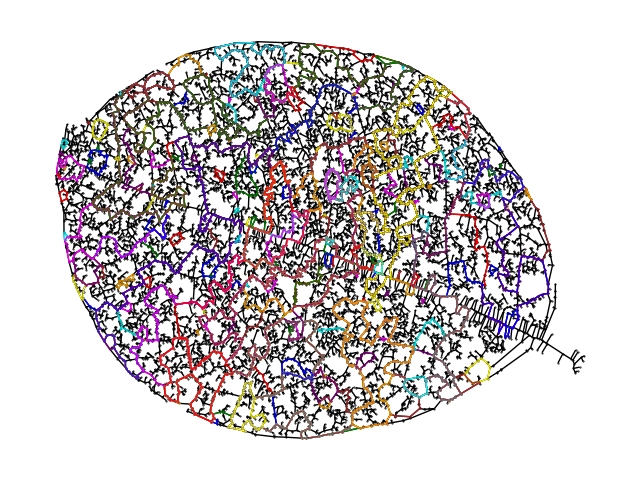

/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

Removing intersecting edges.
((410, 418), (644, 426))
((418, 657), (644, 426))
((426, 644), (657, 418))
((426, 644), (410, 418))
((1202, 1234), (6809, 1210))
((1210, 6809), (1202, 1234))
((1430, 13472), (13027, 13417))
((2101, 6405), (2104, 12385))
((2104, 12385), (6405, 2101))
((2703, 7796), (8229, 2713))
((2713, 8229), (2703, 7796))
((4325, 4343), (11904, 12586))
((7075, 12675), (12311, 7108))
((7108, 12311), (12675, 7075))
((11904, 12586), (4325, 4343))
((12156, 12174), (12169, 12157))
((12157, 12169), (12174, 12156))
((13027, 13417), (1430, 13472))
Pruning.
Applying workaround to remove spurious collinear edges.
Found collinear edges:
[(20.746083967824145, (1567, 1569)), (14.623952953972539, (1567, 1570))]
Found collinear edges:
[(26.368778887161234, (2297, 541)), (14.38966643115816, (2297, 13263))]
Removing offending edges.
Pruning again.
Connected components: 55 



In [5]:
%matplotlib notebook
#for k, network_id in enumerate(networks_to_be_cut[3:4]):
network_id = 'BronxA_009'
path = 'data/networks-BronxA/{}_binary_corrected_graph.'.format(network_id)
_, G = graph_from_data(path + 'node_positions.txt',
                       path + 'edgelist.txt')

pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos=pos, node_size=0.2, edge_size=0.1, node_color='black', edge_color='black')

cycles = nx.cycle_basis(clean_graph(G))
colors = itertools.cycle(['red', 'green', 'blue', 'yellow', 'brown', 'orange', 'purple', 'cyan', 'magenta'])
for cycle in cycles[::5]:
    H = nx.subgraph(G, cycle)
    color = next(colors)
    pos = nx.get_node_attributes(H, 'pos')
    nx.draw(H, pos=pos, node_size=0.2, edge_size=100000.0, node_color=color, edge_color=color)
    

In [4]:
print(G.neighbors(3))

[9, 37, 14477]
